## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning


### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo":

- https://www.uio.no/english/studies/examinations/cheating/index.html

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of _absolutely necessary_ (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment.
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash.
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the assignment

The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm.

### Tools

The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer.

### Beware

There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!


### Initialization


In [236]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn  # for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing _must not be used_ till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.


In [237]:
from sklearn.datasets import make_blobs

X, t_multi = make_blobs(
    n_samples=[400, 400, 400, 400, 400],
    centers=[[0, 1], [4, 2], [8, 1], [2, 0], [6, 0]],
    cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
    n_features=2,
    random_state=2022,
)

In [238]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)
indices[:10]

array([1018, 1295,  643, 1842, 1669,   86,  164, 1653, 1174,  747])

In [239]:
X_train = X[indices[:1000], :]
X_val = X[indices[1000:1500], :]
X_test = X[indices[1500:], :]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`


In [240]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype("int")
t2_val = (t_multi_val >= 3).astype("int")
t2_test = (t_multi_test >= 3).astype("int")

We can plot the two traning sets.


Text(0.5, 1.0, 'Multi-class set')

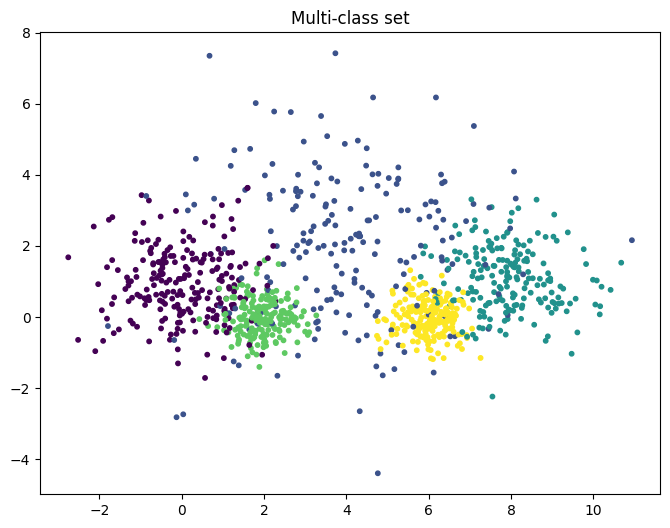

In [241]:
plt.figure(figsize=(8, 6))  # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title("Multi-class set")

Text(0.5, 1.0, 'Binary set')

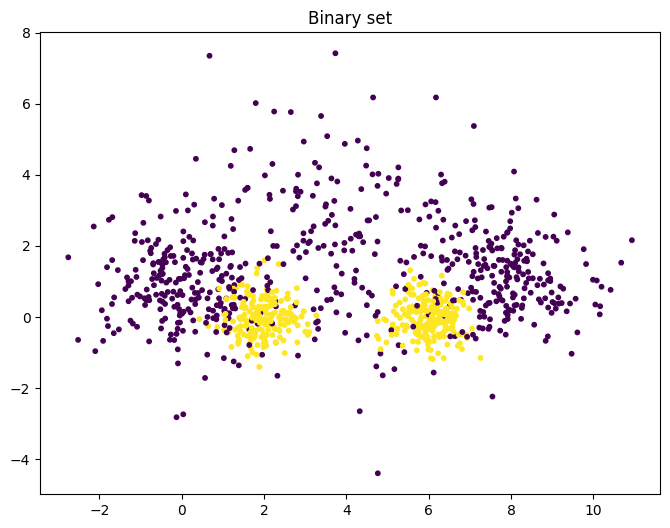

In [242]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title("Binary set")

# Part I: Linear classifiers

## Linear regression


We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7.
We include it here with a little added flexibility.


In [243]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1)) * bias  # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis=1)

In [244]:
class NumpyClassifier:

    """Common methods to all numpy classifiers"""

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def binary_cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # avoid log(0)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def categorical_cross_entropy(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)  # avoid log(0)
        return -np.mean(y_true * np.log(y_pred))

    def accuracy(self, predicted, gold):
        return np.mean(predicted == gold)

In [245]:
class NumpyLinRegClass(NumpyClassifier):
    def __init__(self, bias=-1):
        self.bias = bias

    def fit(self, X_train, t_train, X_val, t_val, eta=0.1, epochs=10):
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""

        if self.bias:
            X_train = add_bias(X_train, self.bias)

        (N, m) = X_train.shape

        self.weights = weights = np.zeros(m)
        self.loss = loss = np.zeros(epochs)
        self.accu = accu = np.zeros(epochs)

        for e in range(epochs):
            weights -= eta / N * X_train.T @ (X_train @ weights - t_train)

            # Predict the values for the validation set and use them to compute
            # loss and accuracy
            pred_val = self.predict(X_val)
            loss[e] = self.mse(pred_val, t_val)
            accu[e] = self.accuracy(pred_val, t_val)

    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.


In [246]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, X_val, t2_val)
cl.accu[-1]

0.522

The following is a small procedure which plots the data set together with the decision boundaries.
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers


In [247]:
def plot_decision_regions(X, t, clf=[], size=(8, 6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Make a mesh of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size)  # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap="Paired")

    plt.scatter(X[:, 0], X[:, 1], c=t, s=10.0, cmap="Paired")

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")


#    plt.show()

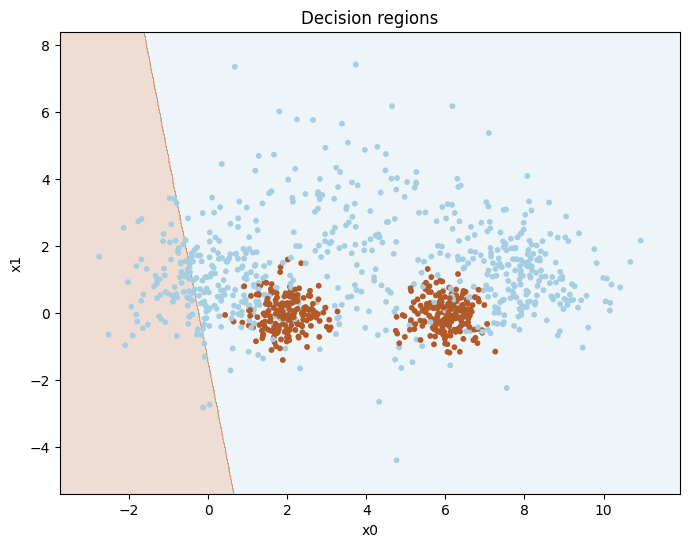

In [248]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive.
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, _eta_ and _epochs_, to get the best accuracy on the validation set.

Report how the accuracy vary with the hyper-parameter settings. It it not sufficient to give the final hyperparemters. You must also show how you found them and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.


In [249]:
# I will try optimizing it using a simple evolutionary algorithm
from typing import Callable, List
import numpy as np


# Randomly swaps two coordinates from each parent to create a child
def single_coordinate_swap(parent1, parent2):
    coord = np.random.choice(len(parent1), 2, replace=False)
    child = parent1.copy()
    child[coord] = np.where(np.random.random() > 0.5, parent1[coord], parent2[coord])
    return child


# Performs a single arithmetic recombination between two parents
def single_arithmetic_recombination(parent1, parent2):
    alpha = np.random.random()
    return alpha * parent1 + (1 - alpha) * parent2


# Selects the mu_percentage best parents using roulette wheel selection
def roulette_wheel_selection(population, n):
    # Probabilities proportional to the fitnesses
    fits = population[:, -1]
    probs = fits / np.sum(fits)

    return population[np.random.choice(len(population), n, p=probs)]


# Evolutionary algorithm which optimizes n hyperparameters fed as a list of
# n-dimensional floating points (the search space)
def ea(
    points,
    fitness: Callable[[np.ndarray], float],
    population_size=100,
    mutation_probability=0.4,
    mu_percentage=60,
    epochs=200,
    crossover=single_arithmetic_recombination,
    parent_selection=roulette_wheel_selection,
) -> List[float]:
    points = np.array(points)
    N = int(population_size * mu_percentage / 100)  # Number of parents to select

    population = points[np.random.choice(len(points), population_size)]
    population = np.c_[population, [fitness(p) for p in population]]

    for _ in range(epochs):
        parents = parent_selection(population, N)

        if np.random.random() < mutation_probability:
            # A mutation just consists in picking a random point from the search space
            mutants = points[np.random.choice(len(points), len(parents))]

            np.append(population, np.c_[mutants, [fitness(m) for m in mutants]])
        else:
            p1s = parents[np.random.choice(len(parents), len(parents))]
            p2s = parents[np.random.choice(len(parents), len(parents))]

            children = np.array([crossover(p1, p2) for p1, p2 in zip(p1s, p2s)])

            np.append(population, np.c_[children, [fitness(c) for c in children]])

        # Survivor selection: the best population_size individuals are kept
        population = population[np.argsort(population[:, -1])][:population_size]

    return population[0]

In [250]:
# Exclude zeroes from the search space
xs = np.linspace(0, 0.2, 100)[1:]  # Learning rate
ys = np.linspace(0, 99, 100)[1:]  # Number of epochs

# I represent the possible solutions as points in a plane
points = [[x, y] for x in xs for y in ys]

# Using the loss as fitness function


def linear_regression_loss(point) -> float:
    cl = NumpyLinRegClass()
    cl.fit(X_train, t2_train, X_val, t2_val, eta=point[0], epochs=int(point[1]))
    return cl.loss[-1]

In [251]:
eta, epochs, mse = ea(points, fitness=linear_regression_loss)
best_param_lin_reg = [eta, epochs]

Best parameters: [0.05656565656565657, 94.0] with MSE 0.338


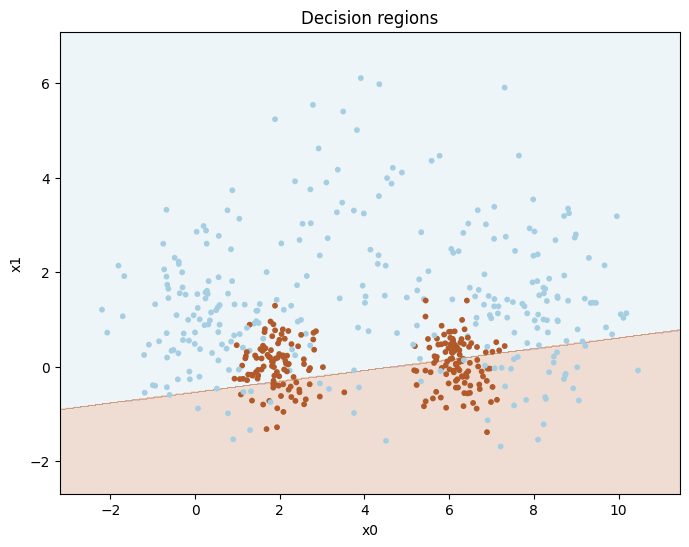

In [252]:
print("Best parameters: {} with MSE {}".format(best_param_lin_reg, mse))

cls = NumpyLinRegClass()
cls.fit(
    X_train,
    t2_train,
    X_val,
    t2_val,
    eta=best_param_lin_reg[0],
    epochs=int(best_param_lin_reg[1]),
)
plot_decision_regions(X_val, t2_val, cls)

### Task: Loss

The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training.

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?


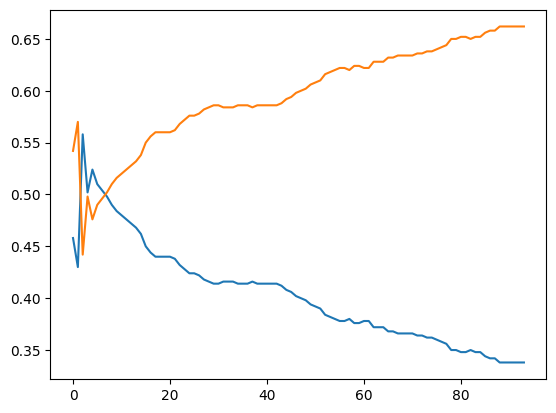

In [253]:
plt.plot(cls.loss)
plt.plot(cls.accu)

#### Answer

We can notice that the functions are mostly monotone but they both have a spike at the start, which is expected since we're looking at the more expolarative part of the algorithm. From the way we calculated the mean squared error we can also notice that the two graphs are symmetric one another.


### Task: Scaling


we have seen in the lectures that scaling the data may improve training speed.

- Implement a scaler, either standard scaler (normalizer) or max-min scaler
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed up the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.


In [254]:
# Scaler class for 2D data
class Scaler:
    def __init__(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)

    def scale(self, X, type):
        if type == "standard":
            return (X - self.mean) / self.std
        elif type == "minmax":
            return (X - self.mean) / (self.std * 2)

In [255]:
import time

scaler_train = Scaler(X_train)
scaler_val = Scaler(X_val)

X_train_standard_scaled = scaler_train.scale(X_train, "standard")
X_val_standard_scaled = scaler_val.scale(X_val, "standard")

X_train_minmax_scaled = scaler_train.scale(X_train, "minmax")
X_val_minmax_scaled = scaler_val.scale(X_val, "minmax")

time_non_normalized = []
time_std_normalized = []
time_minmax_normalized = []

for _ in range(500):
    start = time.time()
    cls = NumpyLinRegClass()
    cls.fit(
        X_train,
        t2_train,
        X_val,
        t2_val,
        eta=best_param_lin_reg[0],
        epochs=int(best_param_lin_reg[1]),
    )
    end = time.time()
    time_non_normalized.append(end - start)

for _ in range(500):
    start = time.time()
    cls = NumpyLinRegClass()
    cls.fit(
        X_train_standard_scaled,
        t2_train,
        X_val_standard_scaled,
        t2_val,
        eta=best_param_lin_reg[0],
        epochs=int(best_param_lin_reg[1]),
    )
    end = time.time()
    time_std_normalized.append(end - start)

for _ in range(500):
    start = time.time()
    cls = NumpyLinRegClass()
    cls.fit(
        X_train_minmax_scaled,
        t2_train,
        X_val_minmax_scaled,
        t2_val,
        eta=best_param_lin_reg[0],
        epochs=int(best_param_lin_reg[1]),
    )
    end = time.time()
    time_minmax_normalized.append(end - start)

In [256]:
print(
    "Mean time \n\tfor non-normalized data:  {}s \n\tfor standard scaled data: {}s \n\tfor minmax scaled data:   {}s".format(
        np.mean(time_non_normalized),
        np.mean(time_std_normalized),
        np.mean(time_minmax_normalized),
    )
)

Mean time 
	for non-normalized data:  0.007963181495666504s 
	for standard scaled data: 0.007981453895568848s 
	for minmax scaled data:   0.00680772066116333s


## Logistic regression

- [x] You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
      You may use code from the solution to weekly exercise set week07.
- [x] In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.
- [x] As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
      The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.
- [x] In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.
- [x] The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.
- [x] Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.
- [x] After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.


In [257]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


class NumpyLogReg(NumpyClassifier):
    def __init__(self, bias=1):
        self.bias = bias

    def fit(
        self,
        X_train,
        t_train,
        X_val,
        t_val,
        eta=0.1,
        epochs=100,
        tol=1e-4,
        n_epochs_no_update=5,
    ):
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""

        (N, m) = X_train.shape

        X_train = add_bias(X_train, self.bias)

        self.weights = weights = np.zeros(m + 1)

        self.train_loss = train_loss = np.zeros(epochs)
        self.val_loss = val_loss = np.zeros(epochs)
        self.train_accu = train_accu = np.zeros(epochs)
        self.val_accu = val_accu = np.zeros(epochs)

        self.epochs_run = epochs_run = 0

        # Counts how many epohcs have passed without an improvement in the loss
        epochs_no_update = 0

        for e in range(epochs):
            epochs_run += 1

            weights -= eta / N * X_train.T @ (self.forward(X_train) - t_train)

            # Saves loss for each epoch, uses the validation set to calculate
            # the binary cross-entropy loss and accuracy
            train_loss[e] = self.binary_cross_entropy(
                t_train, self.predict_probability(X_train[:, 1:])
            )
            val_loss[e] = self.binary_cross_entropy(
                t_val, self.predict_probability(X_val)
            )
            train_accu[e] = self.accuracy(t_train, self.predict(X_train[:, 1:]))
            val_accu[e] = self.accuracy(t_val, self.predict(X_val))

            if e > 0 and train_loss[e] > train_loss[e - 1]:
                epochs_no_update += 1

                if epochs_no_update >= n_epochs_no_update:
                    break
            else:
                epochs_no_update = 0

    def forward(self, X):
        return logistic(X @ self.weights)

    def predict(self, x, threshold=0.5):
        z = add_bias(x, self.bias)
        return (self.forward(z) > threshold).astype("int")

    def predict_probability(self, x):
        z = add_bias(x, self.bias)
        return self.forward(z)

In [258]:
zs = np.linspace(0, 0.1, 100)[1:]  # Tolerance

# I represent the possible solutions as points in a plane
points = np.array([[x, y, z] for x in xs for y in ys for z in zs])


def logistic_regression_loss(point):
    cl = NumpyLogReg()
    cl.fit(
        X_train,
        t2_train,
        X_val,
        t2_val,
        eta=point[0],
        epochs=int(point[1]),
        tol=point[2],
    )
    return cl.train_loss[-1]

In [259]:
eta, epochs, tol, mse = ea(points, fitness=logistic_regression_loss)
best_param_log_reg = [eta, epochs, tol]

In [260]:
print("The best parameters are: {}".format(best_param_log_reg))

The best parameters are: [0.1797979797979798, 97.0, 0.0101010101010101]


The non scaled data has a training accuracy of 75.3%% and a validation accuracy of 70.19999999999999%%
The standard scaled data has a training accuracy of 76.2%% and a validation accuracy of 71.6%%


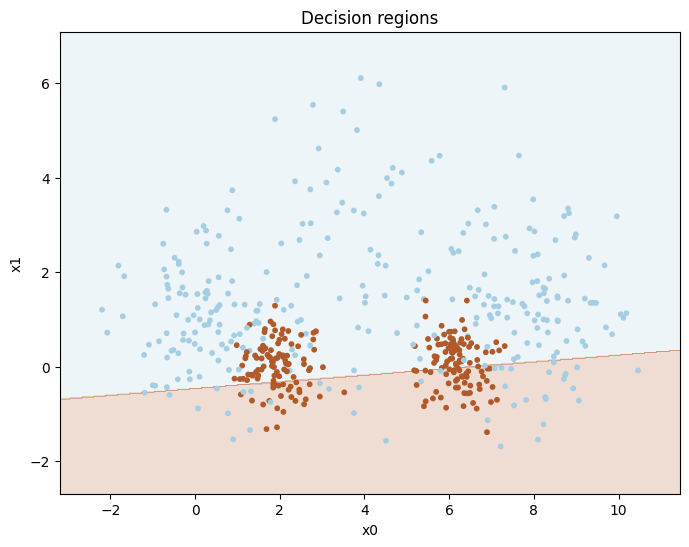

In [261]:
cls = NumpyLogReg()
cls.fit(
    X_train,
    t2_train,
    X_val,
    t2_val,
    eta=best_param_log_reg[0],
    epochs=int(best_param_log_reg[1]),
    tol=best_param_log_reg[2],
)

print(
    "The non scaled data has a training accuracy of {}%% and a validation accuracy of {}%%".format(
        cls.train_accu[-1] * 100, cls.val_accu[-1] * 100
    )
)

cls.fit(
    X_train_standard_scaled,
    t2_train,
    X_val_standard_scaled,
    t2_val,
    eta=best_param_log_reg[0],
    epochs=int(best_param_log_reg[1]),
    tol=best_param_log_reg[2],
)

print(
    "The standard scaled data has a training accuracy of {}%% and a validation accuracy of {}%%".format(
        cls.train_accu[-1] * 100, cls.val_accu[-1] * 100
    )
)

plot_decision_regions(X_val, t2_val, cls)

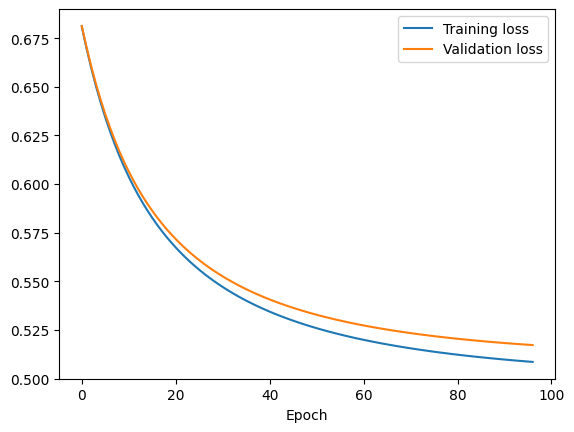

In [262]:
plt.plot(cls.train_loss, label="Training loss")
plt.plot(cls.val_loss, label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

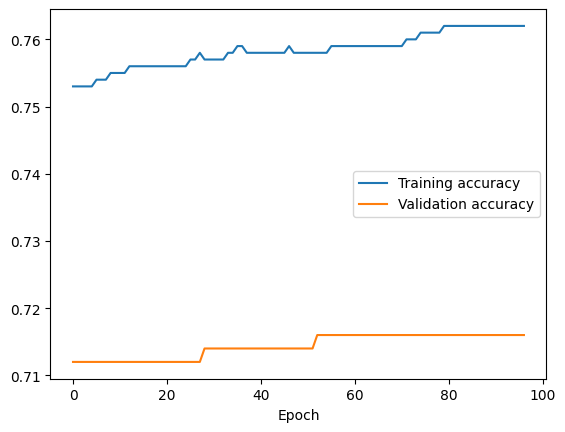

In [263]:
plt.plot(cls.train_accu, label="Training accuracy")
plt.plot(cls.val_accu, label="Validation accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Answer

As expected checks on the validation set perform worse than those on the training set, they still follow the same trend and get better with the number of epochs.
It's interesting to see that the accuracy is already very high after the first epoch when using normalized data.


## Multi-class classifiers

We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).


### "One-vs-rest" with logistic regression

We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.


In [264]:
class NumpyMultiOvRLogReg(NumpyClassifier):
    def fit(
        self,
        X_train,
        t_multi_train,
        X_val,
        t_multi_val,
        eta=0.1,
        epochs=100,
        tol=1e-4,
        n_epochs_no_update=5,
    ):
        self.classes = classes = [cl for cl in np.unique(t_multi_train)]
        self.classifiers = classifiers = [NumpyLogReg() for _ in range(len(classes))]

        for cl, classifier in zip(classes, classifiers):
            classifier.fit(
                X_train,
                t_multi_train == cl,
                X_val,
                t_multi_val == cl,
                eta=eta,
                epochs=epochs,
                tol=tol,
                n_epochs_no_update=n_epochs_no_update,
            )

    def predict(self, x):
        return np.argmax(
            np.array(
                [classifier.predict_probability(x) for classifier in self.classifiers]
            ),
            axis=0,
        )

In [265]:
def multi_ovr_logistic_regression_loss(point):
    cl = NumpyMultiOvRLogReg()
    cl.fit(
        X_train,
        t_multi_train,
        X_val,
        t_multi_val,
        eta=point[0],
        epochs=int(point[1]),
        tol=point[2],
    )
    return np.mean([classifier.train_loss[-1] for classifier in cl.classifiers])

In [266]:
eta, epochs, tol, mse = ea(points, fitness=multi_ovr_logistic_regression_loss)
best_param_multi_ovr_log_reg = [eta, epochs, tol]

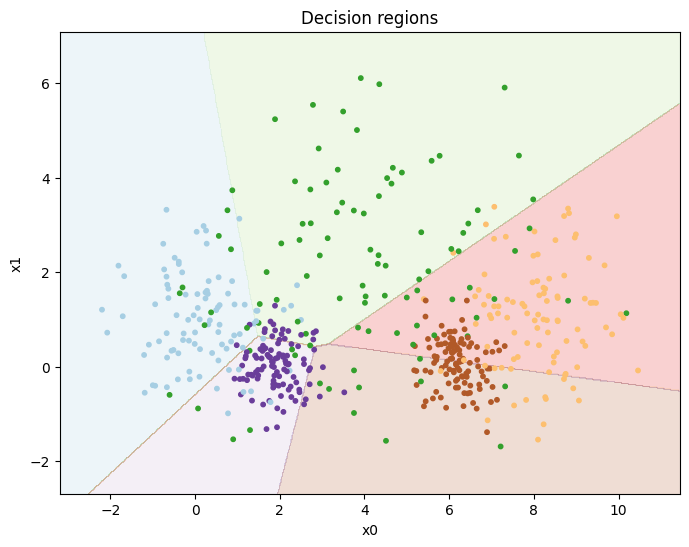

In [267]:
cls = NumpyMultiOvRLogReg()
cls.fit(
    X_train,
    t_multi_train,
    X_val,
    t_multi_val,
    eta=best_param_multi_ovr_log_reg[0],
    epochs=int(best_param_multi_ovr_log_reg[1]),
    tol=best_param_multi_ovr_log_reg[2],
)
plot_decision_regions(X_val, t_multi_val, cls)

In [268]:
print(
    "The accuracy of the various classifiers is: {}".format(
        [classifier.train_accu[-1] for classifier in cls.classifiers]
    )
)

The accuracy of the various classifiers is: [0.92, 0.841, 0.893, 0.779, 0.807]


### For in4050-students: Multi-nominal logistic regression

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks.

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier.

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.


In [269]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)


class NumpyMultinomialLogReg(NumpyClassifier):
    def __init__(self, bias=1):
        self.bias = bias

    def fit(
        self,
        X_train,
        t_multi_train,
        X_val,
        t_multi_val,
        eta=0.1,
        epochs=100,
        tol=1e-4,
        n_epochs_no_update=5,
    ):
        self.classes = classes = [cl for cl in np.unique(t_multi_train)]

        (N, m) = X_train.shape
        k = len(classes)
        t_train = self.onehot_encode(t_multi_train, k)
        t_val = self.onehot_encode(t_multi_val, k)
        X_train = add_bias(X_train, self.bias)

        # Create a matrix of weights, one for each class
        self.weights = weights = np.zeros((m + 1, k))

        self.train_loss = train_loss = np.zeros(epochs)
        self.val_loss = val_loss = np.zeros(epochs)
        self.train_accu = train_accu = np.zeros(epochs)
        self.val_accu = val_accu = np.zeros(epochs)

        self.epochs_run = epochs_run = 0

        # Counts how many epochs have passed without an improvement in the loss
        epochs_no_update = 0

        for e in range(epochs):
            epochs_run += 1

            weights -= eta / N * X_train.T @ (self.forward(X_train) - t_train)

            # Saves loss for each epoch, uses the validation set to calculate
            # the categorical cross-entropy loss and accuracy
            train_loss[e] = self.categorical_cross_entropy(
                self.predict_probability(X_train[:, 1:]), t_train
            )
            val_loss[e] = self.categorical_cross_entropy(
                self.predict_probability(X_val), t_val
            )
            train_accu[e] = self.accuracy(self.predict(X_train[:, 1:]), t_multi_train)
            val_accu[e] = self.accuracy(self.predict(X_val), t_multi_val)

            if e > 0 and train_loss[e] > train_loss[e - 1]:
                epochs_no_update += 1
                if epochs_no_update >= n_epochs_no_update:
                    break
            else:
                epochs_no_update = 0

    def onehot_encode(self, t, k):
        return np.eye(k)[t]

    def forward(self, X):
        return softmax(X @ self.weights)

    def predict(self, x):
        z = add_bias(x, self.bias)
        probabilities = self.forward(z)
        return np.argmax(probabilities, axis=1)

    def predict_probability(self, x):
        z = add_bias(x, self.bias)
        return self.forward(z)

In [270]:
def multinomial_logistic_regression_loss(point):
    cl = NumpyMultinomialLogReg()
    cl.fit(
        X_train,
        t_multi_train,
        X_val,
        t_multi_val,
        eta=point[0],
        epochs=int(point[1]),
        tol=point[2],
    )
    return cl.train_loss[-1]

In [271]:
eta, epochs, tol, mse = ea(points, fitness=multinomial_logistic_regression_loss)
best_param_multinomial_log_reg = [eta, epochs, tol]

The accuracy of the training set is 76.0%%
The accuracy of the validation set is 70.0%%


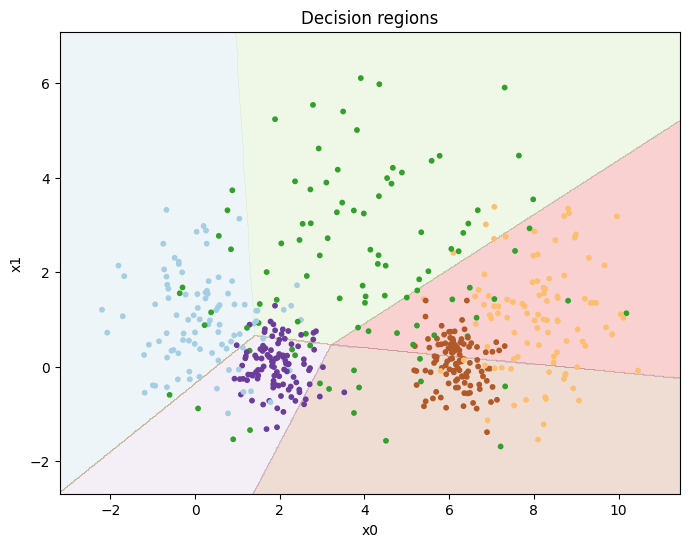

In [272]:
cls = NumpyMultinomialLogReg()
cls.fit(
    X_train,
    t_multi_train,
    X_val,
    t_multi_val,
    eta=best_param_multinomial_log_reg[0],
    epochs=int(best_param_multinomial_log_reg[1]),
    tol=best_param_multinomial_log_reg[2],
)
plot_decision_regions(X_val, t_multi_val, cls)

print("The accuracy of the training set is {}%%".format(cls.train_accu[-1] * 100))
print("The accuracy of the validation set is {}%%".format(cls.val_accu[-1] * 100))

# Part II Multi-layer neural networks


## A first non-linear classifier


The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.


In [273]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""

    def __init__(self, bias=-1, dim_hidden=6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden

        def logistic(x):
            return 1 / (1 + np.exp(-x))

        self.activ = logistic

        def logistic_diff(y):
            return y * (1 - y)

        self.activ_diff = logistic_diff

    def fit(
        self,
        X_train,
        t_train,
        X_val,
        t_val,
        eta=0.001,
        epochs=100,
        tol=1e-4,
        n_epochs_no_update=5,
    ):
        """Intialize the weights. Train *epochs* many epochs.

        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data,
        where the values are 0 or 1.
        """
        self.eta = eta

        T_train = t_train.reshape(-1, 1)
        T_val = t_val.reshape(-1, 1)

        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]

        self.train_loss = train_loss = np.zeros(epochs)
        self.train_accu = train_accu = np.zeros(epochs)
        self.val_loss = val_loss = np.zeros(epochs)
        self.val_accu = val_accu = np.zeros(epochs)

        self.epochs_run = epochs_run = 0

        # Counts how many epohcs have passed without an improvement in the loss
        epochs_no_update = 0

        # Itilaize the wights
        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / np.sqrt(
            dim_in
        )
        self.weights2 = (
            np.random.rand(self.dim_hidden + 1, dim_out) * 2 - 1
        ) / np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)

        for e in range(epochs):
            epochs_run += 1
            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = outputs - T_train
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the jidden layer
            hiddenact_deltas = hiddenout_diffs[:, 1:] * self.activ_diff(
                hidden_outs[:, 1:]
            )
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas
            # Update the weights

            train_loss[e] = self.mse(self.predict_probability(X_train), t2_train)
            train_accu[e] = self.accuracy(self.predict(X_train), t2_train)
            val_loss[e] = self.mse(self.predict_probability(X_val), t2_val)
            val_accu[e] = self.accuracy(self.predict(X_val), t2_val)

            if e > 0 and val_loss[e] > val_loss[e - 1]:
                epochs_no_update += 1

                if epochs_no_update > n_epochs_no_update:
                    break
            else:
                epochs_no_update = 0

    def forward(self, X):
        """Perform one forward step.
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs

    def predict(self, X):
        """Predict the class for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score = forw[:, 0]
        return score > 0.5

    def predict_probability(self, X):
        """Predict the probability for the mebers of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score = forw[:, 0]
        return score

## Improving the classifier

You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

- [x] In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.
- [x] Calculate the loss and the accuracy after each epoch and store them for inspection after training.
- [x] In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.
- [x] The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.
- [x] Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
      Also consider the effect of scaling the data.
- [x] After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.
- [x] The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.


In [274]:
xs = np.linspace(0.0005, 0.001, 100)[1:]
ys = np.linspace(0, 99, 100)[1:]
zs = np.linspace(0, 0.1, 100)[1:]
rs = np.linspace(0, 9, 10)[1:]

points = np.array(
    [
        [eta, epochs, tol, dim_hidden]
        for eta in xs
        for epochs in ys
        for tol in zs
        for dim_hidden in rs
    ]
)


def mlp_binary_logistic_regression_loss(point):
    cl = MLPBinaryLinRegClass(dim_hidden=int(point[3]))
    cl.fit(
        X_train,
        t2_train,
        X_val,
        t2_val,
        eta=point[0],
        epochs=point[1].astype(int),
        tol=point[2],
    )
    return 1 - cl.train_accu[-1]

In [275]:
eta, epochs, tol, dim_hidden, mse = ea(
    points, fitness=mlp_binary_logistic_regression_loss
)
best_param_mlp_binary_log_reg = [eta, epochs, tol, dim_hidden]

In [276]:
print("The best parameters are: {}".format(best_param_mlp_binary_log_reg))

The best parameters are: [0.0007424242424242425, 86.0, 0.01616161616161616, 3.0]


The accuracy of the MLP classifier is: 0.808


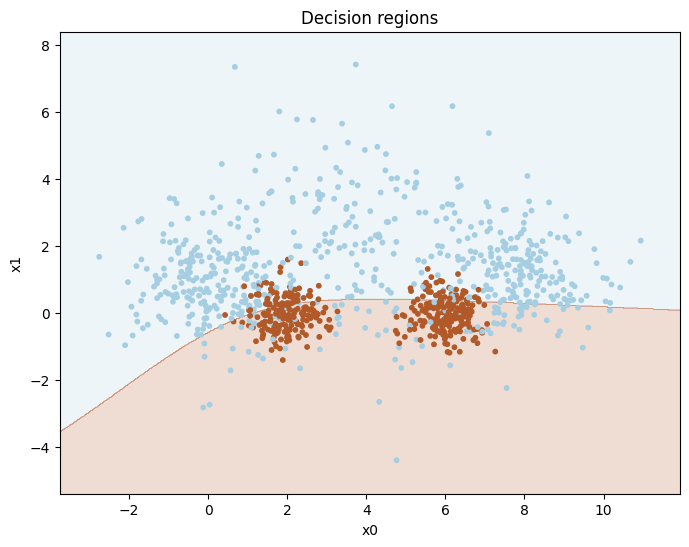

In [277]:
cls = MLPBinaryLinRegClass(dim_hidden=int(best_param_mlp_binary_log_reg[3]))
cls.fit(
    X_train,
    t2_train,
    X_val,
    t2_val,
    eta=best_param_mlp_binary_log_reg[0],
    epochs=best_param_mlp_binary_log_reg[1].astype(int),
    tol=best_param_mlp_binary_log_reg[2],
)

print("The accuracy of the MLP classifier is: {}".format(cls.train_accu[-1]))

plot_decision_regions(X_train, t2_train, cls)

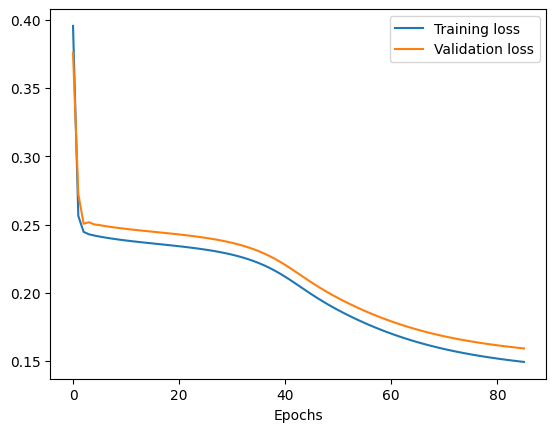

In [278]:
plt.plot(cls.train_loss, label="Training loss")
plt.plot(cls.val_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.show()

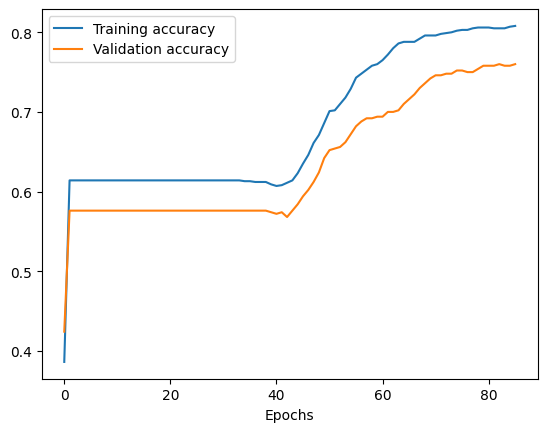

In [279]:
plt.plot(cls.train_accu, label="Training accuracy")
plt.plot(cls.val_accu, label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.show()

### Answer


In [280]:
non_scaled_accuracy = []
standard_scaled_accuracy = []
minmax_scaled_accuracy = []

# I decide to train for more than 10 iterations because 10 is not statistically significant

for _ in range(500):
    cls = MLPBinaryLinRegClass(dim_hidden=int(best_param_mlp_binary_log_reg[3]))
    cls.fit(
        X_train,
        t2_train,
        X_val,
        t2_val,
        eta=best_param_mlp_binary_log_reg[0],
        epochs=best_param_mlp_binary_log_reg[1].astype(int),
        tol=best_param_mlp_binary_log_reg[2],
    )
    non_scaled_accuracy.append(cls.train_accu[-1])

for _ in range(500):
    cls = MLPBinaryLinRegClass(dim_hidden=int(best_param_mlp_binary_log_reg[3]))
    cls.fit(
        X_train_standard_scaled,
        t2_train,
        X_val_standard_scaled,
        t2_val,
        eta=best_param_mlp_binary_log_reg[0],
        epochs=best_param_mlp_binary_log_reg[1].astype(int),
        tol=best_param_mlp_binary_log_reg[2],
    )
    standard_scaled_accuracy.append(cls.train_accu[-1])

for _ in range(500):
    cls = MLPBinaryLinRegClass(dim_hidden=int(best_param_mlp_binary_log_reg[3]))
    cls.fit(
        X_train_minmax_scaled,
        t2_train,
        X_val_minmax_scaled,
        t2_val,
        eta=best_param_mlp_binary_log_reg[0],
        epochs=best_param_mlp_binary_log_reg[1].astype(int),
        tol=best_param_mlp_binary_log_reg[2],
    )
    minmax_scaled_accuracy.append(cls.train_accu[-1])

print(
    "The mean accuracy of the MLP classifier is: {}".format(
        np.mean(non_scaled_accuracy)
    )
)
print(
    "The mean accuracy of the MLP classifier with standard scaled data is: {}".format(
        np.mean(standard_scaled_accuracy)
    )
)
print(
    "The mean accuracy of the MLP classifier with minmax scaled data is: {}".format(
        np.mean(minmax_scaled_accuracy)
    )
)

The mean accuracy of the MLP classifier is: 0.7561800000000001
The mean accuracy of the MLP classifier with standard scaled data is: 0.76508
The mean accuracy of the MLP classifier with minmax scaled data is: 0.693808


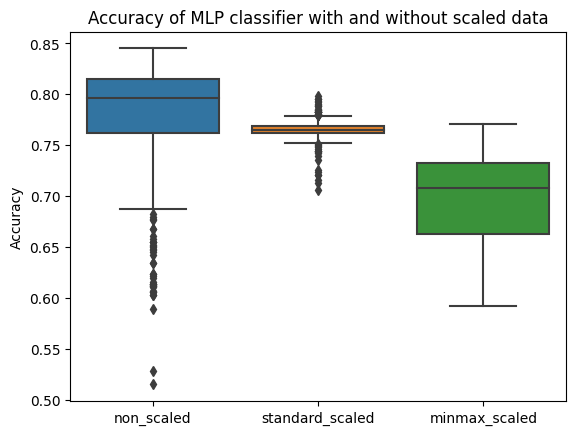

In [281]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(
    {
        "non_scaled": non_scaled_accuracy,
        "standard_scaled": standard_scaled_accuracy,
        "minmax_scaled": minmax_scaled_accuracy,
    }
)

# trim values with accuracy equals to 0 corresponding to models that diverged to infinity
df.loc[
    (df.non_scaled == 0) | (df.standard_scaled == 0) | (df.minmax_scaled == 0),
    ["non_scaled", "standard_scaled", "minmax_scaled"],
] = np.nan
df = df.dropna()

fig = plt.figure()
plt.title("Accuracy of MLP classifier with and without scaled data")
plt.ylabel("Accuracy")

sns.boxplot(data=df)

plt.show()

### Comment

Very interestingly we see that scaling the data actually generally worsens the classifier but we can notice that there is much less variance and in particular a lot less outliers, these characteristics are enough to make the mean accuracy better in the standard scaled classifier.

From these results we conclude that we should generaly avoid minimax scaling for this problem.


## For IN4050-students: Multi-class neural network


The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier..


In [282]:
class MLPMultiLinRegClass(NumpyClassifier):
    def fit(
        self,
        X_train,
        t_multi_train,
        X_val,
        t_multi_val,
        eta=0.1,
        epochs=100,
        tol=1e-4,
        n_epochs_no_update=5,
        dim_hidden=10,
    ):
        self.classes = classes = [cl for cl in np.unique(t_multi_train)]
        self.classifiers = classifiers = [
            MLPBinaryLinRegClass(dim_hidden=dim_hidden) for _ in range(len(classes))
        ]

        for cl, classifier in zip(classes, classifiers):
            classifier.fit(
                X_train,
                t_multi_train == cl,
                X_val,
                t_multi_val == cl,
                eta=eta,
                epochs=epochs,
                tol=tol,
                n_epochs_no_update=n_epochs_no_update,
            )

    def predict(self, x):
        return np.argmax(
            np.array(
                [classifier.predict_probability(x) for classifier in self.classifiers]
            ),
            axis=0,
        )

In [283]:
def mlp_multi_logistic_regression_loss(point):
    cl = MLPMultiLinRegClass()
    cl.fit(
        X_train,
        t_multi_train,
        X_val,
        t_multi_val,
        eta=point[0],
        epochs=point[1].astype(int),
        tol=point[2],
        dim_hidden=point[3].astype(int),
    )
    return np.mean([classifier.train_loss[-1] for classifier in cl.classifiers])

In [284]:
eta, epochs, tol, dim_hidden, mse = ea(
    points, fitness=mlp_multi_logistic_regression_loss.astype(float)
)
best_param_mlp_multi_log_reg = [eta, epochs, tol, dim_hidden]

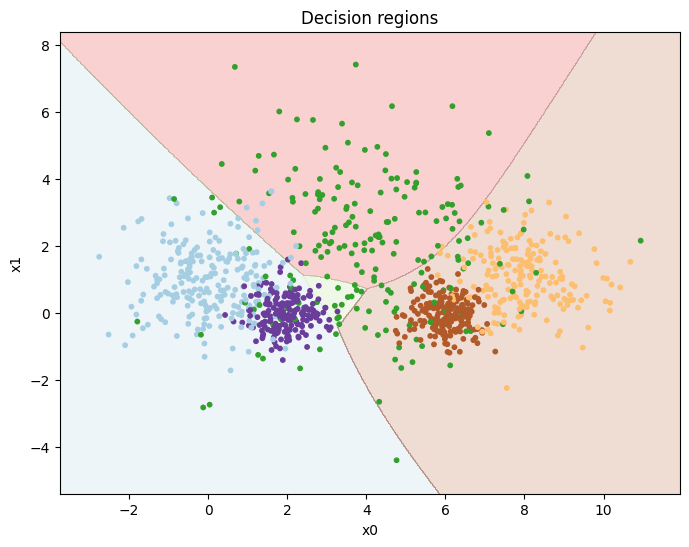

In [307]:
cls = MLPMultiLinRegClass()
cls.fit(
    X_train,
    t_multi_train,
    X_val,
    t_multi_val,
    eta=best_param_mlp_multi_log_reg[0],
    epochs=best_param_mlp_multi_log_reg[1].astype(int),
    tol=best_param_mlp_multi_log_reg[2],
    dim_hidden=best_param_mlp_multi_log_reg[3].astype(int),
)
plot_decision_regions(X_train, t_multi_train, cls)

# Part III: Final testing

We can now perform a final testing on the held-out test set.

## Binary task (X, t2)

Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here?

Also report precision and recall for class 1.

## For IN4050-students: Multi-class task (X, t_multi)

The following part is only mandatory for in4050-students. In3050-students are also welcome to do it. It requires the earlier IN4050-only tasks.

Compare the three multi-class classfiers, the one-vs-rest and the multinomial logistic regression from part one, and the multi-class neural network from part two. Evaluate on test, validation and training set as above.

Comment on what you see


In [286]:
cls1 = NumpyLinRegClass()
cls1.fit(
    X_train,
    t2_train,
    X_val,
    t2_val,
    eta=best_param_lin_reg[0],
    epochs=best_param_lin_reg[1].astype(int),
)

train_accu_lin_reg = cls1.predict(X_train) == t2_train
val_accu_lin_reg = cls1.predict(X_val) == t2_val
test_accu_lin_reg = cls1.predict(X_test) == t2_test

cls2 = NumpyLogReg()
cls2.fit(
    X_train,
    t2_train,
    X_val,
    t2_val,
    eta=best_param_log_reg[0],
    epochs=best_param_log_reg[1].astype(int),
)

train_accu_log_reg = cls2.predict(X_train) == t2_train
val_accu_log_reg = cls2.predict(X_val) == t2_val
test_accu_log_reg = cls2.predict(X_test) == t2_test

cls3 = MLPBinaryLinRegClass(dim_hidden=best_param_mlp_binary_log_reg[3].astype(int))
cls3.fit(
    X_train,
    t2_train,
    X_val,
    t2_val,
    eta=best_param_mlp_binary_log_reg[0],
    epochs=best_param_mlp_binary_log_reg[1].astype(int),
    tol=best_param_mlp_binary_log_reg[2],
)

train_accu_mlp_binary_lin_reg = cls3.predict(X_train) == t2_train
val_accu_mlp_binary_lin_reg = cls3.predict(X_val) == t2_val
test_accu_ml_binary_lin_reg = cls3.predict(X_test) == t2_test

df = pd.DataFrame(
    columns=["train", "val", "test"],
    index=[
        "linear regression",
        "logistic regression",
        "mlp binary logistic regression",
    ],
)
df["train"] = [
    np.mean(train_accu_lin_reg),
    np.mean(train_accu_log_reg),
    np.mean(train_accu_mlp_binary_lin_reg),
]
df["val"] = [
    np.mean(val_accu_lin_reg),
    np.mean(val_accu_log_reg),
    np.mean(val_accu_mlp_binary_lin_reg),
]
df["test"] = [
    np.mean(test_accu_lin_reg),
    np.mean(test_accu_log_reg),
    np.mean(test_accu_ml_binary_lin_reg),
]

print(df)

                                train    val   test
linear regression               0.705  0.662  0.684
logistic regression             0.753  0.702  0.726
mlp binary logistic regression  0.813  0.772  0.788


In [287]:
def confusion_matrix(cls, X, t):
    predicted = cls.predict(X)

    cfm = pd.crosstab(
        t, predicted, rownames=["Actual"], colnames=["Predicted"], margins=False
    )

    print(cfm)

    return cfm.to_numpy()


cfm = confusion_matrix(cls1, X_test, t2_test)


def precision():
    true_positives = cfm[1, 1]
    false_positives = cfm[0, 1]
    return true_positives / (true_positives + false_positives)


def recall():
    true_positives = cfm[1, 1]
    false_negatives = cfm[1, 0]
    return true_positives / (true_positives + false_negatives)


print("The precision of the linear regression classifier is: {}".format(precision()))
print("The recall of the linear regression classifier is: {}".format(recall()))

Predicted  False  True 
Actual                 
0            252     46
1            112     90
The precision of the linear regression classifier is: 0.6617647058823529
The recall of the linear regression classifier is: 0.44554455445544555


### Comment

The MLP classifier seems to perform the best of the three, it's also expected that the accuracy on the training set is higher on all three classifiers compared to the validation and the test set.


In [288]:
cls4 = NumpyMultiOvRLogReg()
cls4.fit(
    X_train,
    t_multi_train,
    X_val,
    t_multi_val,
    eta=best_param_multi_ovr_log_reg[0],
    epochs=best_param_multi_ovr_log_reg[1].astype(int),
    tol=best_param_multi_ovr_log_reg[2],
)

train_accu_multi_ovr_log_reg = cls4.predict(X_train) == t_multi_train
val_accu_multi_ovr_log_reg = cls4.predict(X_val) == t_multi_val
test_accu_multi_ovr_log_reg = cls4.predict(X_test) == t_multi_test

cls5 = NumpyMultinomialLogReg()
cls5.fit(
    X_train,
    t_multi_train,
    X_val,
    t_multi_val,
    eta=best_param_multinomial_log_reg[0],
    epochs=best_param_multinomial_log_reg[1].astype(int),
    tol=best_param_multinomial_log_reg[2],
)

train_accu_multinomial_log_reg = cls5.predict(X_train) == t_multi_train
val_accu_multinomial_log_reg = cls5.predict(X_val) == t_multi_val
test_accu_multinomial_log_reg = cls5.predict(X_test) == t_multi_test

cls6 = MLPMultiLinRegClass()
cls6.fit(
    X_train,
    t_multi_train,
    X_val,
    t_multi_val,
    eta=best_param_mlp_multi_log_reg[0],
    epochs=best_param_mlp_multi_log_reg[1].astype(int),
    tol=best_param_mlp_multi_log_reg[2],
    dim_hidden=best_param_mlp_multi_log_reg[3].astype(int),
)

train_accu_mlp_multi_lin_reg = cls6.predict(X_train) == t_multi_train
val_accu_mlp_multi_lin_reg = cls6.predict(X_val) == t_multi_val
test_accu_mlp_multi_lin_reg = cls6.predict(X_test) == t_multi_test

df = pd.DataFrame(
    columns=["train", "val", "test"],
    index=[
        "multi-class ovr logistic regression",
        "multinomial logistic regression",
        "mlp multi-class logistic regression",
    ],
)
df["train"] = [
    np.mean(train_accu_multi_ovr_log_reg),
    np.mean(train_accu_multinomial_log_reg),
    np.mean(train_accu_mlp_multi_lin_reg),
]log
df["val"] = [
    np.mean(val_accu_multi_ovr_log_reg),
    np.mean(val_accu_multinomial_log_reg),
    np.mean(val_accu_mlp_multi_lin_reg),
]
df["test"] = [
    np.mean(test_accu_multi_ovr_log_reg),
    np.mean(test_accu_multinomial_log_reg),
    np.mean(test_accu_mlp_multi_lin_reg),
]

print(df)


                                     train    val   test
multi-class ovr logistic regression  0.738  0.688  0.724
multinomial logistic regression      0.760  0.700  0.740
mlp multi-class logistic regression  0.518  0.494  0.454
